In [1]:
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

In [2]:
torch.__version__

'1.13.0+cpu'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
driver = GraphDatabase.driver(uri=URL, auth=(USER, PWD))

def fetch_data(query):
  with driver.session() as session:
    result = session.run(query)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

### Preporcess neo4j database

In [5]:
def preprocess_neo4j_db(file_path:str) -> None:
    """Execute some type casts and data preprocessing steps on neo4j."""

    with open(file_path, mode='r', encoding='utf-8') as f:
        query = f.read()

    queries = [query for query in query.split(';')[:-1]] 

    with driver.session() as session:
        for query in queries:
            result = session.run(query)
            print(result)


preprocess_neo4j_db(file_path='./neo4j_cypher_queries/01_db_preprocessing.txt')

### Get data from neo4j

In [6]:
user_query = """
MATCH (u:User)
RETURN u.userId AS userId
"""

user_df = fetch_data(user_query)
print(user_df.shape)
user_df.head()

(671, 1)


,userId
0,1
1,2
2,3
3,4
4,5


In [7]:
# Unforunately there are too many null values in revenue and budged. Hence I do not use them as features.
movie_query = """
MATCH (m:Movie)
RETURN m.movieId AS movieId,
    m.imdbRating AS imdbRating,
    m.imdbVotes AS imdbVotes,
    m.runtime AS runtime,
    m.year AS year,
    m.genreEmbedding AS genreEmbedding,
    m.title AS title,
    m.plot AS plot
"""

movie_df = fetch_data(movie_query)
print(movie_df.shape)
movie_df.head()

(9125, 8)


,movieId,imdbRating,imdbVotes,runtime,year,genreEmbedding,title,plot
0,1,8.3,591836.0,81.0,1995.0,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Toy Story,A cowboy doll is profoundly threatened and jea...
1,2,6.9,198355.0,104.0,1995.0,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Jumanji,When two kids find and play a magical board ga...
2,3,6.6,18615.0,101.0,1995.0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Grumpier Old Men,John and Max resolve to save their beloved bai...
3,4,5.6,7210.0,124.0,1995.0,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Waiting to Exhale,"Based on Terry McMillan's novel, this film fol..."
4,5,5.9,25938.0,106.0,1995.0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Father of the Bride Part II,"In this sequel, George Banks deals not only wi..."


In [8]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         9125 non-null   int64  
 1   imdbRating      9058 non-null   float64
 2   imdbVotes       9055 non-null   float64
 3   runtime         9062 non-null   float64
 4   year            9096 non-null   float64
 5   genreEmbedding  9125 non-null   object 
 6   title           9125 non-null   object 
 7   plot            9083 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 570.4+ KB


In [9]:
rating_query = """
MATCH (u:User) -[r:RATED]-> (m:Movie)
RETURN u.userId AS userId,
    m.movieId AS movieId,
    r.rating AS rating
"""

rating_df = fetch_data(rating_query)
print(rating_df.shape)
rating_df.head()

(100004, 3)


,userId,movieId,rating
0,1,1343,2.0
1,1,1339,3.5
2,1,1405,1.0
3,1,1371,2.5
4,1,1263,2.0


### Data cleansing

The genreEmbeddings must be converted from a list into a proper columns.

In [10]:
query = """
MATCH(g:Genre)
WITH g ORDER BY g.name
RETURN g.name AS header
"""

header_df = fetch_data(query)
genre_headers = header_df['header'].to_list()

In [11]:
genre_embed = np.array(movie_df['genreEmbedding'].values.tolist())
genre_embed.shape

(9125, 20)

In [12]:
genre_df = pd.DataFrame(genre_embed, columns=genre_headers)
genre_df.shape

(9125, 20)

In [13]:
movie_df = pd.concat([movie_df, genre_df], axis=1)
movie_df.shape

(9125, 28)

In [14]:
movie_df.drop(columns=['genreEmbedding', 'plot', 'title', '(no genres listed)'], axis=1, inplace=True)
print(movie_df.shape)
# movie_df.head(20)

(9125, 24)


In [15]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      9125 non-null   int64  
 1   imdbRating   9058 non-null   float64
 2   imdbVotes    9055 non-null   float64
 3   runtime      9062 non-null   float64
 4   year         9096 non-null   float64
 5   Action       9125 non-null   int32  
 6   Adventure    9125 non-null   int32  
 7   Animation    9125 non-null   int32  
 8   Children     9125 non-null   int32  
 9   Comedy       9125 non-null   int32  
 10  Crime        9125 non-null   int32  
 11  Documentary  9125 non-null   int32  
 12  Drama        9125 non-null   int32  
 13  Fantasy      9125 non-null   int32  
 14  Film-Noir    9125 non-null   int32  
 15  Horror       9125 non-null   int32  
 16  IMAX         9125 non-null   int32  
 17  Musical      9125 non-null   int32  
 18  Mystery      9125 non-null   int32  
 19  Romanc

In [16]:
movie_df['imdbRating'].fillna(movie_df['imdbRating'].mean(), inplace=True)
movie_df['imdbVotes'].fillna(movie_df['imdbVotes'].mean(), inplace=True)
movie_df['runtime'].fillna(movie_df['runtime'].mean(), inplace=True)
movie_df['year'].fillna(movie_df['year'].mean(), inplace=True)

assert not movie_df.isnull().values.any(), 'Null values in dataset!'

### Data profiling


C:\Users\roman\AppData\Local\Temp\ipykernel_16168\3178207162.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  movie_df[movie_features].hist(bins=30, ax=ax)


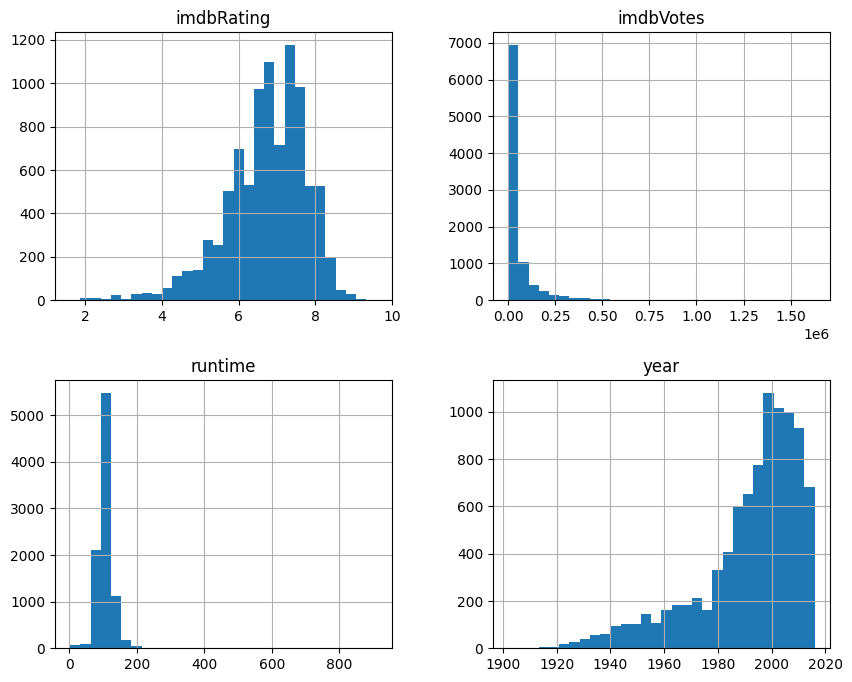

In [17]:
_, ax = plt.subplots(figsize=(10,8))

movie_features = movie_df.columns[1:5]
movie_df[movie_features].hist(bins=30, ax=ax)
plt.show()

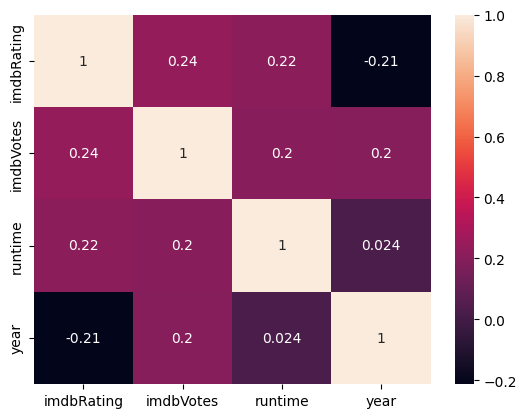

In [18]:
corr_matrix = movie_df[movie_features].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

### Encoding & Scaling data

In [19]:
user_encoder, movie_encoder = LabelEncoder(), LabelEncoder()
scaler = StandardScaler()

In [20]:
user_df['userId'] = user_encoder.fit_transform(user_df['userId'])
movie_df['movieId'] = movie_encoder.fit_transform(movie_df['movieId'])

rating_df['userId'] = user_encoder.transform(rating_df['userId'])
rating_df['movieId'] = movie_encoder.transform(rating_df['movieId'])

In [21]:
features_to_scale = ['imdbRating', 'imdbVotes', 'runtime', 'year']
scaled_features = scaler.fit_transform(movie_df[features_to_scale])
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale)

In [22]:
movie_df.drop(columns=features_to_scale, axis=1, inplace=True)
movie_df = pd.concat([movie_df, scaled_features_df], axis=1)
movie_df.head()

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,1.528928,5.144229,-0.876122,0.158905
1,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0.174897,1.394602,-0.058951,0.158905
2,2,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,-0.115253,-0.318207,-0.165539,0.158905
3,3,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,-1.082418,-0.426889,0.651632,0.158905
4,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,-0.792268,-0.248423,0.012107,0.158905


In [23]:
movie_df.describe()

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year
count,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,...,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9.125000e+03,9.125000e+03,9.125000e+03,9.125000e+03
mean,4562.000000,0.169315,0.122411,0.048986,0.063890,0.363288,0.120548,0.054247,0.478356,0.071671,...,0.059507,0.169315,0.086795,0.189479,0.040219,0.018411,7.697222e-16,3.114708e-18,-1.993413e-16,-5.095662e-15
std,2634.304937,0.375051,0.327778,0.215851,0.244571,0.480973,0.325619,0.226516,0.499559,0.257957,...,0.236584,0.375051,0.281549,0.391910,0.196484,0.134439,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.951079e+00,-4.954719e-01,-3.682925e+00,-4.650468e+00
25%,2281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.988353e-01,-4.503885e-01,-4.497720e-01,-3.582321e-01
50%,4562.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.818045e-02,-3.532937e-01,-1.300096e-01,2.623321e-01
75%,6843.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.551962e-01,0.000000e+00,3.318695e-01,7.277552e-01
max,9124.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.786243e+00,1.500774e+01,2.857755e+01,1.244892e+00


In [24]:
# _, ax = plt.subplots(figsize=(10,8))

# movie_df[movie_features].hist(bins=30, ax=ax)
# plt.show()

In [25]:
safe_date = datetime.now().strftime('%Y%m%d')
user_df.to_csv(f'./datasets/{safe_date}_movieLens100k_users.csv', index=False)
movie_df.to_csv(f'./datasets/{safe_date}_movieLens100k_movies.csv', index=False)
rating_df.to_csv(f'./datasets/{safe_date}_movieLens100k_ratings.csv', index=False)

In [26]:
rating_df

,userId,movieId,rating
0,0,1087,2.0
1,0,1083,3.5
2,0,1140,1.0
3,0,1111,2.5
4,0,1017,2.0
...,...,...,...
99999,670,3113,2.0
100000,670,3199,3.5
100001,670,3213,4.0
100002,670,3220,3.5


### Create Pytorch Geometric (heterogenious) Dataset

In [27]:
x_user = torch.eye(len(user_df['userId'].values))
x_user.size()

torch.Size([671, 671])

In [28]:
x_movie = movie_df.drop(columns=['movieId'], axis=1)
x_movie = torch.Tensor(x_movie.values)
x_movie.size()

torch.Size([9125, 23])

In [29]:
edge_index = torch.Tensor(rating_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
edge_index.size(), edge_index

(torch.Size([2, 100004]),
 tensor([[   0,    0,    0,  ...,  670,  670,  670],
         [1087, 1083, 1140,  ..., 3213, 3220, 3223]]))

In [30]:
edge_label = torch.Tensor(rating_df['rating'].values)
edge_label.size(), edge_label

(torch.Size([100004]),
 tensor([2.0000, 3.5000, 1.0000,  ..., 4.0000, 3.5000, 3.5000]))

In [31]:
data = HeteroData()
data['user'].x = x_user
data['movie'].x = x_movie

data[('user', 'rates', 'movie')].edge_index = edge_index
data[('user', 'rates', 'movie')].edge_label = edge_label

data

HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  }
)

In [32]:
data = ToUndirected()(data)
# data = AddSelfLoops()(data)
# data = NormalizeFeatures()(data)
del data[('movie', 'rev_rates', 'user')].edge_label
data

HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)

In [33]:
# data = data.to(device)

### Train / Test Split

In [34]:
# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [35]:
print('Train:', train_data)
# print('Val:', val_data)
# print('Test:', test_data)

Train: HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 80004],
    edge_label=[80004],
    edge_label_index=[2, 80004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 80004] }
)


In [36]:
# Slicing edge label to get the corresponding split (hence this gives train split)
train_data['user', 'movie'].edge_label_index.size(), train_data['user', 'movie'].edge_label_index

(torch.Size([2, 80004]),
 tensor([[  29,  118,  586,  ...,  283,  159,  101],
         [ 244, 2021, 1863,  ...,  606, 2608, 1829]]))

In [37]:
train_data['user', 'movie'].edge_label.size(), train_data['user', 'movie'].edge_label

(torch.Size([80004]),
 tensor([4.0000, 2.0000, 3.5000,  ..., 3.0000, 5.0000, 3.0000]))

In [38]:
# fetaure matrix for all the node types
data.x_dict

{'user': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 'movie': tensor([[ 0.0000,  1.0000,  1.0000,  ...,  5.1442, -0.8761,  0.1589],
         [ 0.0000,  1.0000,  0.0000,  ...,  1.3946, -0.0590,  0.1589],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.3182, -0.1655,  0.1589],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.1932],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.4935, -0.6985, -2.8922],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -1.2669,  1.1415]])}

### GNN Model

In [39]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.lin_out(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=64).to(device)

In [40]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters())

In [41]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    # loss = weighted_mse_loss(pred, target, weight)
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [42]:
EPOCHS = 300
train_losses, val_losses, test_losses = [], [], []
for epoch in range(1, EPOCHS+1):
    train_loss = train()
    # train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    
    train_losses.append(train_loss), val_losses.append(val_rmse), test_losses.append(test_rmse)
    
    print(f'Epoch: {epoch:03d}\tTrain: {train_loss:.4f}\t'
          f'Val: {val_rmse:.4f}\tTest: {test_rmse:.4f}')
    # break

Epoch: 001	Train: 3.6089	Val: 3.5664	Test: 3.5434
Epoch: 002	Train: 3.5573	Val: 3.5126	Test: 3.4898
Epoch: 003	Train: 3.5032	Val: 3.4541	Test: 3.4315
Epoch: 004	Train: 3.4444	Val: 3.3886	Test: 3.3663
Epoch: 005	Train: 3.3786	Val: 3.3153	Test: 3.2933
Epoch: 006	Train: 3.3049	Val: 3.2331	Test: 3.2114
Epoch: 007	Train: 3.2224	Val: 3.1408	Test: 3.1195
Epoch: 008	Train: 3.1297	Val: 3.0370	Test: 3.0163
Epoch: 009	Train: 3.0256	Val: 2.9201	Test: 2.8999
Epoch: 010	Train: 2.9082	Val: 2.7881	Test: 2.7685
Epoch: 011	Train: 2.7757	Val: 2.6395	Test: 2.6206
Epoch: 012	Train: 2.6265	Val: 2.4729	Test: 2.4549
Epoch: 013	Train: 2.4592	Val: 2.2879	Test: 2.2708
Epoch: 014	Train: 2.2734	Val: 2.0848	Test: 2.0688
Epoch: 015	Train: 2.0694	Val: 1.8663	Test: 1.8515
Epoch: 016	Train: 1.8500	Val: 1.6392	Test: 1.6261
Epoch: 017	Train: 1.6226	Val: 1.4191	Test: 1.4084
Epoch: 018	Train: 1.4050	Val: 1.2351	Test: 1.2278
Epoch: 019	Train: 1.2348	Val: 1.1303	Test: 1.1281
Epoch: 020	Train: 1.1713	Val: 1.1293	Test: 1.1334


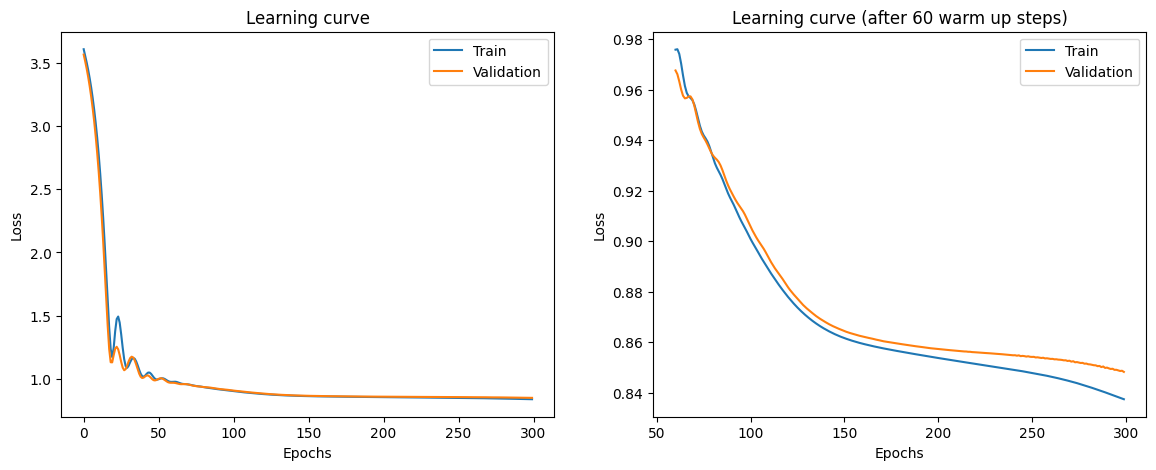

In [43]:
SKIP_WARM_UP_STEPS = 60

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax0.plot(train_losses, label='Train')
ax0.plot(val_losses, label='Validation')
ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), train_losses[SKIP_WARM_UP_STEPS:], label='Train')
ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), val_losses[SKIP_WARM_UP_STEPS:], label='Validation')
ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()

### Inspect test results

In [44]:
model.eval()
pred = model(test_data.x_dict, test_data.edge_index_dict,
                test_data['user', 'movie'].edge_label_index)
pred = pred.clamp(min=0, max=5)
target = test_data['user', 'movie'].edge_label.float()
rmse = F.mse_loss(pred, target).sqrt()

In [45]:
pred[:20], target[:20]

(tensor([4.7768, 3.2380, 2.5795, 3.0256, 1.9364, 3.8835, 2.8801, 4.3732, 1.8794,
         3.9824, 4.4202, 4.1466, 4.4275, 3.4754, 3.0976, 3.0995, 2.6048, 2.6213,
         3.2537, 2.9622], grad_fn=<SliceBackward0>),
 tensor([5.0000, 4.0000, 3.0000, 2.0000, 1.0000, 4.0000, 3.5000, 5.0000, 2.5000,
         4.5000, 5.0000, 5.0000, 4.5000, 3.0000, 3.0000, 2.0000, 4.0000, 2.0000,
         4.5000, 3.0000]))

#### Evaluation

Mean squared Error (MSE) can be used as loss function. However, it is not a well suited metric to evaluate the model's recommendations. `Recall@k` fits better for evaluating the recommendations done by the model.  

In [46]:
def create_rec_dict_per_user() -> dict:
    """ Return a dictionnairy, with link predictions for each user.
    
        The dict keys are userId's and values a list of tuples. The
        first tuple value is the predicted rating and the second one
        the ground truth (rating). """

    user_rec_dict = defaultdict(list)
    test_users_unique = test_data['user', 'movie'].edge_label_index[0].unique()

    with torch.no_grad():
        for user_id in tqdm(test_users_unique):
            user_id = user_id.item()

            idxs = (test_data['user', 'movie'].edge_label_index[0] == user_id).nonzero().squeeze()
            edge_idxs = test_data['user', 'movie'].edge_label_index[:,idxs]
            
            true_ratings = test_data['user', 'movie'].edge_label[idxs]
            if true_ratings.ndimension() == 0:
                true_ratings = test_data['user', 'movie'].edge_label[idxs].unsqueeze(dim=0)

            pred_ratings = model(test_data.x_dict, test_data.edge_index_dict, edge_idxs)

            ratings = [(pred.item(), gt.item()) for gt, pred in zip(true_ratings, pred_ratings)] 
            user_rec_dict[user_id] = ratings
        
        return user_rec_dict


def recall_at_k(user_rec_dict:dict, k:int, threshold:float) -> dict:
    """" """
    with torch.no_grad():
        # precisions = dict()
        recalls = dict()

        # k = 20
        # threshold = 4.0

        for uid, user_ratings in user_rec_dict.items():
            
            user_ratings.sort(key=lambda x: x[0], reverse=True) 
             
            n_rel = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings])
            # n_rec_k = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings[:k]])
            # print(f'n_rel: {n_rel}, n_rec_k: {n_rec_k}')

            n_rel_and_rec_k = sum([((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k]])
            # print(n_rel_and_rec_k)
            
            # print(f'uid: {uid}, n_rel: {n_rel}, n_rec_k: {n_rec_k}, n_rel_and_rec_k: {n_rel_and_rec_k}')
            
            # precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
        return recalls

user_rec_dict = create_rec_dict_per_user()

100%|██████████| 657/657 [03:34<00:00,  3.06it/s]


In [47]:
k = 20
threshold = 4.0
recalls = recall_at_k(user_rec_dict, k, threshold)
rcl_at_k = sum(recalls.values()) / len(recalls.values())
print(f'Recall@{k} (Threshold={threshold}):', round(rcl_at_k, 4))

threshold = 3.5
recalls = recall_at_k(user_rec_dict, k=k, threshold=threshold)
rcl_at_k = sum(recalls.values()) / len(recalls.values())
print(f'Recall@{k} (Threshold={threshold}):', round(rcl_at_k, 4))

Recall@20 (Threshold=4.0): 0.354
Recall@20 (Threshold=3.5): 0.6656
